<a href="https://colab.research.google.com/github/rawar/tensorflow-notebooks/blob/master/lstm_sentiment_detection_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0
#!pip install tensorflow==2.0.0-alpha0

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


### get the Yelp sentiment data from GitHub Gist 

In [0]:
url = 'https://gist.githubusercontent.com/rawar/3d5343ce39dd16bc457ef4ae56c87f4a/raw/6e6c150745de44e002f0b7fb435d0ccd1e10faa7/yelp-sentiment-data.csv'
sentiment_data = pd.read_csv(url)

### take a look to the data

In [5]:
sentiment_data.head(5)

,Unnamed: 0,stars,text,sentiment
0,0,5.0,hands down best bloody mary ever so many thing...,pos
1,1,5.0,its true this hotel carries you while in vegas...,pos
2,2,4.0,first time lemme not exaggerate but yo nothin...,pos
3,3,4.0,sushisamba had very tasty sushis my table and ...,pos
4,4,5.0,good food nice setting jazz ambience\n\nmade f...,pos


### remove some empty values

In [0]:
sentiment_data = sentiment_data.dropna()

In [0]:
sentiment_data = sentiment_data.applymap(lambda x: x.strip() if type(x)==str else x)

In [8]:
print(sentiment_data['text'].values)

['hands down best bloody mary ever so many things in my bm veggies  mmm bacon  nailed it its an appetizer i also had the burger with fries who knew fries could be so good the presentation doesnt disappoint ether very nice great seating outside although we sat inside would love to see this restaurant near my hometown seriously get the bm you rock guy'
 'its true this hotel carries you while in vegas we visited the venetian to experience the awesome interior and romantic evening events the entire hotel sparkled its huge too  weekendinvegas'
 'first time  lemme not exaggerate but yo nothing but love and fun cups full and aint nothing but love nothing but good vibes tonight some people dapper some people coolin all age groups people eating'
 ...
 'if i could give this place  stars i would handsdown the best service ive received at a shisha spot worldwide \n\ni was taken care of from the moment i walked in to when i walked out the staff were so attentive and checked on me nonstop they def k

### tokenize text reviews

In [0]:
vocab_size = 4700

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, lower=False, split=" ")

In [0]:
tokenizer.fit_on_texts(sentiment_data['text'].values)

In [12]:
print('Number of words: %d' % len(tokenizer.word_index))

Number of words: 25474


In [0]:
X = tokenizer.texts_to_sequences(sentiment_data['text'].values)

### fill empty words with none to bring every review to the same world length

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=vocab_size)

In [15]:
print(X.shape[1])

4700


In [65]:
embed_dim = 128
lstm_out = 196

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim,input_length = X.shape[1]),
    #tf.keras.layers.LSTM(60, return_sequences=True, recurrent_dropout=0.5),
    tf.keras.layers.LSTM(60, return_sequences=True, dropout=0.2),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.LSTM(60, recurrent_dropout=0.5),
    tf.keras.layers.LSTM(60, dropout=0.2),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax') # classification layer with two classes (neg, pos)
])

#model = tf.keras.models.Sequential([
#    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=X.shape[1]),
#    tf.keras.layers.LSTM(lstm_out, dropout=0.2),
#    tf.keras.layers.Dense(2,activation='softmax') # classification layer with two classes (neg, pos)
#])


model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())  

W0414 16:53:50.444332 140555401680768 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fd4ea52cb70>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0414 16:53:50.453006 140555401680768 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fd59714dba8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4700, 128)         601600    
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 4700, 60)          45360     
_________________________________________________________________
dropout (Dropout)            (None, 4700, 60)          0         
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (None, 60)                29040     
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 122       
Total params: 679,782
Trainable params: 679,782
Non-trainable params: 0
________________________________________________

In [17]:
print(sentiment_data['sentiment'].head(5))

0    pos
1    pos
2    pos
3    pos
4    pos
Name: sentiment, dtype: object


### 1 = postive, 0 = negativ

In [18]:
Y = pd.get_dummies(sentiment_data['sentiment']).values
print(Y)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [20]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,4690,4691,4692,4693,4694,4695,4696,4697,4698,4699
0,0,0,0,0,0,0,0,0,0,0,...,23,4,130,115,27,1,1282,228,435,19
1,0,0,0,0,0,0,0,0,0,0,...,150,11,6,133,4391,2,144,858,26,208
2,0,0,0,0,0,0,0,0,0,0,...,16,9,41,375,210,2,252,344,183,173
3,0,0,0,0,0,0,0,0,0,0,...,309,2,120,34,1706,16,29,9,4,387
4,0,0,0,0,0,0,0,0,0,0,...,579,6,219,18,2048,70,618,97,80,283


In [21]:
pd.DataFrame(Y_train).head()

,0,1
0,0,1
1,0,1
2,1,0
3,0,1
4,1,0


In [0]:
num_epochs = 5
batch_size = 10

In [67]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size = batch_size, epochs = num_epochs, verbose = 1)

Train on 5251 samples, validate on 1313 samples
Epoch 1/5
5251/5251 [==============================] - 451s 86ms/sample - loss: 0.6446 - accuracy: 0.6591 - val_loss: 0.6494 - val_accuracy: 0.6352
Epoch 2/5
5251/5251 [==============================] - 449s 85ms/sample - loss: 0.4915 - accuracy: 0.7640 - val_loss: 0.4074 - val_accuracy: 0.8180
Epoch 3/5
5251/5251 [==============================] - 451s 86ms/sample - loss: 0.2871 - accuracy: 0.8829 - val_loss: 0.4099 - val_accuracy: 0.8431
Epoch 4/5
5251/5251 [==============================] - 449s 85ms/sample - loss: 0.2100 - accuracy: 0.9229 - val_loss: 0.4440 - val_accuracy: 0.8271
Epoch 5/5
5251/5251 [==============================] - 450s 86ms/sample - loss: 0.1483 - accuracy: 0.9482 - val_loss: 0.4427 - val_accuracy: 0.8203


In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

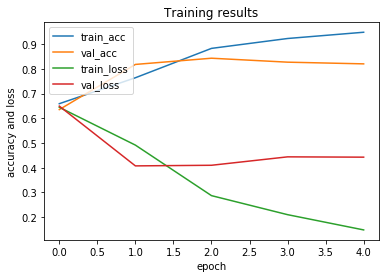

In [68]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Training results')
pyplot.ylabel('accuracy and loss')
pyplot.xlabel('epoch')
pyplot.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper left')
pyplot.show()



In [27]:
score,acc = model.evaluate(X_val, Y_val, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

1313/1313 - 31s - loss: 0.7129 - accuracy: 0.7845
Score: 0.71
Validation Accuracy: 0.78


In [0]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    
    result = model.predict(X_val[x].reshape(1,X_val.shape[1]), batch_size=1, verbose = 0)[0]
    
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
            
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

In [30]:
print("positive accuracy: %.2f" % (pos_correct/pos_cnt*100))
print("negative accuracy: %.2f" % (neg_correct/neg_cnt*100))

positive accuracy: 83.57
negative accuracy: 69.52


### Serialize the Keras model to JSON and save the model weight

In [0]:
from google.colab import files

In [0]:
model_json = model.to_json()
with open("yelp-sentiment-model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
files.download("yelp-sentiment-model.json")

In [39]:
model.save_weights("yelp-sentiment-model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
files.download('yelp-sentiment-model-model.h5')

### Load model and use it to predict new reviews

In [40]:
!ls -l

total 6736
drwxr-xr-x 1 root root    4096 Apr  4 20:20 sample_data
-rw-r--r-- 1 root root 3441848 Apr 14 16:39 yelp-sentiment-model.h5
-rw-r--r-- 1 root root    1824 Apr 14 16:34 yelp-sentiment-model.json
-rw-r--r-- 1 root root 3441848 Apr 14 16:34 yelp-sentiment-model-model.h5


In [37]:
!pip install h5py

In [41]:
json_file = open('yelp-sentiment-model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("yelp-sentiment-model.h5")
 
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_val, Y_val, verbose=0)

W0414 16:39:26.932587 140555401680768 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fd4e30d0240>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [42]:
xval = X_val[1].reshape(1,X_val.shape[1])
print(xval)

[[   0    0    0 ...   44   10 1258]]


In [0]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def sequence_to_text(list_of_indices):
    words = []
    for letter in list_of_indices:
        w = reverse_word_map.get(letter)
        if(w != None):
            words.append(w)
    return(words)

In [0]:
xval_str = list(map(sequence_to_text, xval))

In [63]:
print(xval.shape)

(1, 4700)


In [64]:
yresult = loaded_model.predict(xval)
print("words=%s, predicted sentiment=%s" % (xval_str, yresult))

words=[['i', 'took', 'my', 'family', 'of', 'here', 'while', 'we', 'were', 'all', 'in', 'town', 'on', 'vacation', 'i', 'love', 'the', 'atmosphere', 'and', 'the', 'cocktails', 'are', 'amazing', 'i', 'had', 'reserved', 'a', 'table', 'online', 'several', 'months', 'in', 'advance', 'and', 'everything', 'was', 'ready', 'for', 'us', 'once', 'we', 'arrived', 'we', 'were', 'all', 'seated', 'and', 'served', 'promptly', 'the', 'service', 'was', 'excellent', 'i', 'tipped', 'over', 'the', 'added', 'as', 'they', 'just', 'did', 'that', 'good', 'of', 'a', 'job', 'taking', 'care', 'of', 'everyone', 'would', 'have', 'been', 'stars', 'had', 'the', 'food', 'the', 'amazing', 'atmosphere', 'and', 'cocktails', 'we', 'were', 'all', 'by', 'the', 'food', 'but', 'will', 'definitely', 'be', 'back', 'again', 'and', 'again', 'even', 'if', 'its', 'just', 'for', 'cocktails']], predicted sentiment=[[0.0193097 0.9806903]]


In [61]:
# 1 = positiv, 0 = negativ
result = loaded_model.predict_classes(xval)
print(result)

[1]


In [62]:
yhat = loaded_model.predict_proba(xval) 
print(yhat)

[[0.0193097 0.9806903]]
